In [1]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import os
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

# Prepare data for model
Read Data from excel

In [2]:
def read_excel():
    column_names_to_load = [
        'Siedlungsfläche_in_%', 
        'Landwirtschafts-fläche_in_%',
        'Betriebe_total',
        'Wohnungen - Total',
        'Anzahl_Privathaushalte',
        'Gemeindename',
        'Gemeindetypologien',
        "Ständige Wohnbevölkerung Bevölkerungs-dichte1 in Pers./km2"]

    # Load all data from excel
    data = pd.read_excel('C:\\Users\\jonas.hodel\\Downloads\\HSLU\\Alle_Daten.xlsx', header=[0,1], index_col=[0,1])

    # Extract wanted columns
    column_mask = data.columns.isin(column_names_to_load, level=1)
    data = data.loc[:, column_mask]

    # Drop top level column names
    data = data.droplevel(0,axis=1)

    # Reset index
    data = data.reset_index()

    data = data.drop_duplicates(subset=['Gemeindecode' ,'Jahr']) # Todo data cleaning

    data['Betriebe_total'] = data['Betriebe_total'].replace('X', 0) # Todo data cleaning

    # Remove Kanton Luzern from dataset
    indexNames = data[data['Gemeindename'] == 'Kanton Luzern'].index
    data.drop(indexNames , axis=0, inplace=True)
    return data

Define Train / Verification / Test split

In [3]:
def train_verification_test_split(data, train_length, verification_length):
    start_year = 1991
    amount_of_years = 30

    # Define length of splits
    test_length = amount_of_years - train_length - verification_length

    # Define years where train and validation split ends
    train_data_end_year = start_year + train_length
    verification_data_end_year = train_data_end_year + verification_length

    # Check that all data is used
    assert train_length + verification_length + test_length == amount_of_years, f'Train, verification and test set must sum up to {amount_of_years}'

    # Apply splits
    train = data[data['Jahr'] < train_data_end_year]
    verification = data[(data['Jahr'] >= train_data_end_year) & (data['Jahr'] < verification_data_end_year)]
    test = data[data['Jahr'] > verification_data_end_year]

    # Check that the splits have the correct length
    assert len(train['Jahr'].unique()) == train_length, f'Train set wrong extracted, expected {train_length} actual {len(train["Jahr"].unique())}'
    assert len(verification['Jahr'].unique()) == verification_length, f'Verification set wrong extracted, expected {verification_length} actual {len(verification["Jahr"].unique())}'
    assert len(test['Jahr'].unique()) == test_length, f'Test set wrong extracted, expected {test_length} actual {len(test["Jahr"].unique())}'
    
    return train, verification, test

Define X and Y Split

In [4]:
def x_y_split(data):
    y_column_name = "Ständige Wohnbevölkerung Bevölkerungs-dichte1 in Pers./km2"

    x_column_names = [
        'Jahr',
        'Siedlungsfläche_in_%', 
        'Landwirtschafts-fläche_in_%',
        'Betriebe_total',
        'Wohnungen - Total',
        'Anzahl_Privathaushalte',
        'Gemeindename',
        'Gemeindetypologien']

    # Execute the Y split
    y = data[y_column_name]
    y.name = "y"

    x = data[x_column_names]

    assert len(x) == len(y), 'X and Y split need to have the same length'

    return x, y

Set dummy variables and scale the data

In [5]:
def set_dummy_variables(x):
    # Set dummie variables for the column Gemeindetypologien and Gemeindename in the X split
    return pd.get_dummies(x, columns=['Gemeindetypologien', 'Gemeindename'])

def scale(x, scaler):
    # Store the column names that it can be reapplied after scaling
    x_columns = x.columns

    # Scale the data with the StandardScaler
    if not scaler:
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)
    
    # Create pandas dataframes from ndArrays and reapply columnnames
    x = pd.DataFrame(x, columns=x_columns)

    return x, scaler

Extract data which is used for visualisation

In [6]:
def get_jahre(x):
    # All years from the x set
    return list(x['Jahr'].unique())

def get_gemeinde_and_gemeindetypologien(x):
    # All Gemeinde dummy variable column names
    gemeinden = x.columns.tolist()[11:]

    # All Gemeindetypologien dummy variable column names
    gemeinden_typologien = x.columns.tolist()[6:11]

    return gemeinden, gemeinden_typologien

# Model Evaluation

In [7]:
def clean_output(name): 
    directory = f'./{name}'

    prepare_folder(directory)
    prepare_folder(f'{directory}/Gemeinden')

    return directory

def prepare_folder(folder):
    # create folder if it doesn't exist otherwise clear the entire folder
    if not os.path.exists(folder):
        os.makedirs(folder)
    else: 
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
            except Exception as e:
                print(f"Error deleting file: {file_path} - {e}")

## Metrics

In [8]:
def evaluate(folder, y, y_pred, coeff):
    # calculate the R2 and MAPE and write it to a file
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    with open(f'{folder}/metric.txt', 'w') as f:
        f.write(f"R2: {r2} \n")
        f.write(f"MAPE: {mape}")

    # write the coefficients from the model to a file
    with open(f'{folder}/coeff.txt', 'w') as f:
        for c in coeff:
            f.write(f'{c}\n')

In [9]:
def get_coeff(model):
    # get the coefficients from the diffrent models
    type_switch = {
        LinearRegression: lambda x: x.coef_,
        DecisionTreeRegressor: lambda x: x.feature_importances_,
        RandomForestRegressor: lambda x: x.feature_importances_,
        SVR: lambda x: x.dual_coef_,
        linear_model.Lasso: lambda x: x.coef_,
        linear_model.Ridge: lambda x: x.coef_,
        GradientBoostingRegressor: lambda x: x.feature_importances_,
        KNeighborsRegressor: lambda x: []
    }

    return type_switch[type(model)](model)

## Visualtions

## Plot for a single gemeinde

In [10]:
def plot_gemeinde(folder, gemeinden, jahre_train, jahre_verification, x_list, y_list, y_pred_list):    
    # Concat the train and validation set for the X data set
    x = pd.concat(x_list, axis=0).reset_index()

    # Concat the train and validation set for the Y data set
    y = pd.concat(y_list, axis=0).reset_index()
    
    # Concat the predicted values from the train and validation set
    y_pred = pd.concat(y_pred_list, axis=0).reset_index()

    # Concat the X, Y, and the predicted values
    visualisation_all_gemeinde_data = pd.concat([pd.DataFrame(x), y, y_pred], axis=1)

    # Loop over all gemeinde
    for gemeinde in gemeinden:

        # Extract the data for one gemeinde. Get the rows where the gemeinde dummy variable is positive
        visualisation_gemeinde_data = visualisation_all_gemeinde_data[visualisation_all_gemeinde_data[gemeinde] > 0]

        # Extract the expected and the predicted value
        gemeinde_data_y = visualisation_gemeinde_data['y']
        gemeinde_pred = visualisation_gemeinde_data['pred']

        # Plot the data
        plt.figure()

        # Set title on plot
        plt.title(gemeinde)
        
        # plot the expected data as dots
        plt.scatter(jahre_train, gemeinde_data_y[:len(jahre_train)], label='Train')
        plt.scatter(jahre_verification, gemeinde_data_y[len(jahre_train):len(jahre_train) + len(jahre_verification)], color='orange', label='Verification')

        # plot the prediction as line
        plt.plot(jahre_train + jahre_verification, gemeinde_pred, color="black", label='Prediction')

        # Show legend
        plt.legend()
        
        # Save the image
        plt.savefig(f'{folder}/Gemeinden/{gemeinde}.png')

        # Close the plot that it doesn't display in the jupyter notebook
        plt.close()


## Plot to compare Gemeindetypologien

This comparison is only made on the validation set

In [11]:
def plot_gemeinde_typologie(folder, gemeinden_typologien, x, y, y_pred):
    # Concat the X, Y, and the predicted values
    visualisation_all_gemeindetypologien_data = pd.concat([x.reset_index(), y.reset_index(), y_pred.reset_index()], axis=1)

    # Calculate delta for each prediction
    visualisation_all_gemeindetypologien_data['Delta'] = visualisation_all_gemeindetypologien_data['pred'] - visualisation_all_gemeindetypologien_data['y']   

    # Calculate the absolute percentage error for each prediction
    visualisation_all_gemeindetypologien_data['Delta_Percent'] = 100
    visualisation_all_gemeindetypologien_data['Delta_Percent'] = (abs(visualisation_all_gemeindetypologien_data['Delta']) / visualisation_all_gemeindetypologien_data['pred'] ) * 100

    plot_violin_plot(folder, gemeinden_typologien, visualisation_all_gemeindetypologien_data)
    plot_density(folder, visualisation_all_gemeindetypologien_data)

def plot_violin_plot(folder, gemeinden_typologien, visualisation_all_gemeindetypologien_data):
    # Plot the data
    plt.figure()

    # Extract the data for each Gemeindetypologie
    gemeinden_typologien_violin_party = []

    # Loop over all Gemeindetypologien
    for gemeinden_typologie in gemeinden_typologien: 
        gemeinden_typologien_violin_party.append(
            # Extract the data for one Gemeindetypologie. Get the rows where the Gemeindetypologie dummy variable is positive
            visualisation_all_gemeindetypologien_data[visualisation_all_gemeindetypologien_data[gemeinden_typologie] > 0]['Delta_Percent']
        )
        
    # Create violin plot
    violin_parts = plt.violinplot(gemeinden_typologien_violin_party, showmeans=False, showmedians=True)

    # Set lables
    plt.xticks(list(range(len(gemeinden_typologien))), [gemeinden_typologie[19:] for gemeinden_typologie in gemeinden_typologien])
    plt.title("Absolute Percentage error of predictions")
    plt.ylabel('Absolute Percentage Error')
    plt.xlabel('Gemeindekategorien')

    # Set color
    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_color('red')
        pc.set_edgecolor('black')

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('red')
        vp.set_linewidth(1)
    
    # Save the image
    plt.savefig(f'{folder}/topologien.png')

    # Close the plot that it doesn't display in the jupyter notebook
    plt.close()

def plot_density(folder, visualisation_all_gemeindetypologien_data):
    # Create density plot
    sns.set_style('whitegrid')
    sns.kdeplot(visualisation_all_gemeindetypologien_data['Delta_Percent'])
    
    # Plot mean and median
    plt.axvline(x=np.mean(visualisation_all_gemeindetypologien_data['Delta_Percent']), color='red', linestyle='--', label='Mean')
    plt.axvline(x=np.median(visualisation_all_gemeindetypologien_data['Delta_Percent']), color='green', linestyle='--', label='Median')
    
    # Calculate 15% and 85% quantiles
    cutoff15 = np.percentile(visualisation_all_gemeindetypologien_data['Delta_Percent'], q=85)
    cutoff85 = np.percentile(visualisation_all_gemeindetypologien_data['Delta_Percent'], q=15)

    # Plot quantiles
    plt.axvline(x=cutoff15, color='blue', linestyle='--', label='15% quantile')
    plt.axvline(x=cutoff85, color='blue', linestyle='--', label='85% quantile')
    
    # Show legend
    plt.legend()

    # Save the image
    plt.savefig(f'{folder}/density.png')

    # Close the plot that it doesn't display in the jupyter notebook
    plt.close()

# Define size of train & validation split
Size of test set is fixed to 8 points

In [57]:
AMOUNT_OF_POINTS_FOR_TRAIN_AND_VERIFICATION = 22

for verification_length in range(1, 10):
    TRAIN_LENGTH = AMOUNT_OF_POINTS_FOR_TRAIN_AND_VERIFICATION - verification_length
    VERIFICATION_LENGTH = verification_length

    MODELS = [
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=30 Gamma=0.1', SVR(kernel='poly', degree=3, C=30, gamma=0.1))
    ]

    # Load data if not already loaded
    if 'data' not in locals() or 'data' not in globals():
        data = read_excel()

    # Split
    train, verification, test = train_verification_test_split(data, TRAIN_LENGTH, VERIFICATION_LENGTH)

    x_train, y_train = x_y_split(train)
    x_verification, y_verification = x_y_split(verification)
    x_test, y_test = x_y_split(test)

    # Set dummy variables
    x_train = set_dummy_variables(x_train)
    x_verification = set_dummy_variables(x_verification)
    x_test = set_dummy_variables(x_test)

    # Extract data for visualisations before scaling
    jahre_train = get_jahre(x_train)
    jahre_verification = get_jahre(x_verification)
    gemeinden, gemeinden_typologien = get_gemeinde_and_gemeindetypologien(x_test)

    # Scale the data
    x_train, scaler = scale(x_train, None)
    x_verification, scaler = scale(x_verification, scaler)
    x_test, scaler = scale(x_test, scaler)

    for name, model in MODELS:
        print("Trying model:", name)

        # Prepare folder for output
        directory = clean_output(name)

        # Train Model
        model.fit(x_train, y_train)

        # Prediction
        y_pred_train = pd.Series(model.predict(x_train), name = 'pred')
        y_pred_verification = pd.Series(model.predict(x_verification), name = 'pred')
        
        # Evaluation
        coeff = get_coeff(model)

        evaluate(directory, y_verification, y_pred_verification, zip(x_verification.columns, coeff))

        plot_gemeinde(directory, 
            gemeinden, 
            jahre_train, 
            jahre_verification,
            [x_train, x_verification], 
            [y_train, y_verification], 
            [y_pred_train, y_pred_verification]
            )
        
        plot_gemeinde_typologie(directory, 
                                gemeinden_typologien, 
                                x_verification, 
                                y_verification,
                                y_pred_verification
                                )


Trying model: T21 V1 SVR POLY3 C=30 Gamma=0.1
Trying model: T20 V2 SVR POLY3 C=30 Gamma=0.1
Trying model: T19 V3 SVR POLY3 C=30 Gamma=0.1
Trying model: T18 V4 SVR POLY3 C=30 Gamma=0.1
Trying model: T17 V5 SVR POLY3 C=30 Gamma=0.1
Trying model: T16 V6 SVR POLY3 C=30 Gamma=0.1
Trying model: T15 V7 SVR POLY3 C=30 Gamma=0.1
Trying model: T14 V8 SVR POLY3 C=30 Gamma=0.1
Trying model: T13 V9 SVR POLY3 C=30 Gamma=0.1
Trying model: T12 V10 SVR POLY3 C=30 Gamma=0.1
Trying model: T11 V11 SVR POLY3 C=30 Gamma=0.1
Trying model: T10 V12 SVR POLY3 C=30 Gamma=0.1
Trying model: T9 V13 SVR POLY3 C=30 Gamma=0.1
Trying model: T8 V14 SVR POLY3 C=30 Gamma=0.1


# Compare Metric files

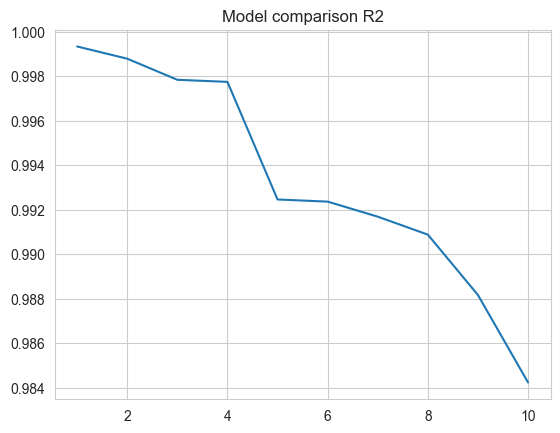

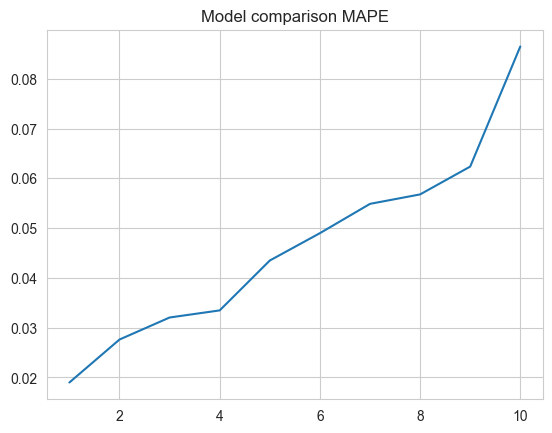

In [59]:
model_numbers = list(range(1, 11))
# List folders from where we will load the metric files
folders = [f'T{22-x} V{x} SVR POLY3 C=30 Gamma=0.1' for x in model_numbers]

R2s = []
MAPEs = []

# Loop over all folders
for folder in folders:
    file = f'./{folder}/metric.txt'

    with open(file, 'r') as file:
        # read the contents of the file
        contents = file.read()
        
        # split in rows of file
        parts = contents.split('\n')

        # extract r2
        r2 = parts[0][4:]
        R2s.append(float(r2))

        # extract mape
        mape = parts[1][6:]
        MAPEs.append(float(mape))

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison R2')

# plot the expected data as dots
plt.plot(model_numbers, R2s)

# Save the image
plt.savefig('model_comparison_R2.png')

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison MAPE')

# plot the expected data as dots
plt.plot(model_numbers, MAPEs)

# Save the image
plt.savefig('model_comparison_MAPE.png')


# Try diffrent models

In [12]:
for x in [6, 7]:
    TRAIN_LENGTH = 30 - (2 * x)
    VERIFICATION_LENGTH = x

    MODELS = [
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor', KNeighborsRegressor()),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} LinearRegression', LinearRegression()),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} DecisionTreeRegressor', DecisionTreeRegressor()),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} RandomForestRegressor', RandomForestRegressor()),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor', GradientBoostingRegressor()),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=30 Gamma=0.1', SVR(kernel='poly', degree=1, C=30, gamma=0.1)),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=30 Gamma=0.1', SVR(kernel='poly', degree=2, C=30, gamma=0.1)),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=30 Gamma=0.1', SVR(kernel='poly', degree=3, C=30, gamma=0.1)),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=30 Gamma=0.1', SVR(kernel='poly', degree=4, C=30, gamma=0.1)),
        (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=30 Gamma=0.1', SVR(kernel='poly', degree=5, C=30, gamma=0.1))
    ]

    # Load data if not already loaded
    if 'data' not in locals() or 'data' not in globals():
        data = read_excel()

    # Split
    train, verification, test = train_verification_test_split(data, TRAIN_LENGTH, VERIFICATION_LENGTH)

    x_train, y_train = x_y_split(train)
    x_verification, y_verification = x_y_split(verification)
    x_test, y_test = x_y_split(test)

    # Set dummy variables
    x_train = set_dummy_variables(x_train)
    x_verification = set_dummy_variables(x_verification)
    x_test = set_dummy_variables(x_test)

    # Extract data for visualisations before scaling
    jahre_train = get_jahre(x_train)
    jahre_verification = get_jahre(x_verification)
    gemeinden, gemeinden_typologien = get_gemeinde_and_gemeindetypologien(x_test)

    # Scale the data
    x_train, scaler = scale(x_train, None)
    x_verification, scaler = scale(x_verification, scaler)
    x_test, scaler = scale(x_test, scaler)

    for name, model in MODELS:
        print("Trying model:", name)

        # Prepare folder for output
        directory = clean_output(name)

        # Train Model
        model.fit(x_train, y_train)

        # Prediction
        y_pred_train = pd.Series(model.predict(x_train), name = 'pred')
        y_pred_verification = pd.Series(model.predict(x_verification), name = 'pred')
        
        # Evaluation
        coeff = get_coeff(model)

        evaluate(directory, y_verification, y_pred_verification, zip(x_verification.columns, coeff))

        plot_gemeinde(directory, 
            gemeinden, 
            jahre_train, 
            jahre_verification,
            [x_train, x_verification], 
            [y_train, y_verification], 
            [y_pred_train, y_pred_verification]
            )
        
        plot_gemeinde_typologie(directory, 
                                gemeinden_typologien, 
                                x_verification, 
                                y_verification,
                                y_pred_verification
                                )


Trying model: T18 V6 KNeighborsRegressor
Trying model: T18 V6 LinearRegression
Trying model: T18 V6 DecisionTreeRegressor
Trying model: T18 V6 RandomForestRegressor
Trying model: T18 V6 GradientBoostingRegressor
Trying model: T18 V6 SVR POLY1 C=30 Gamma=0.1
Trying model: T18 V6 SVR POLY2 C=30 Gamma=0.1
Trying model: T18 V6 SVR POLY3 C=30 Gamma=0.1
Trying model: T18 V6 SVR POLY4 C=30 Gamma=0.1
Trying model: T18 V6 SVR POLY5 C=30 Gamma=0.1
Trying model: T16 V7 KNeighborsRegressor
Trying model: T16 V7 LinearRegression
Trying model: T16 V7 DecisionTreeRegressor
Trying model: T16 V7 RandomForestRegressor
Trying model: T16 V7 GradientBoostingRegressor
Trying model: T16 V7 SVR POLY1 C=30 Gamma=0.1
Trying model: T16 V7 SVR POLY2 C=30 Gamma=0.1
Trying model: T16 V7 SVR POLY3 C=30 Gamma=0.1
Trying model: T16 V7 SVR POLY4 C=30 Gamma=0.1
Trying model: T16 V7 SVR POLY5 C=30 Gamma=0.1


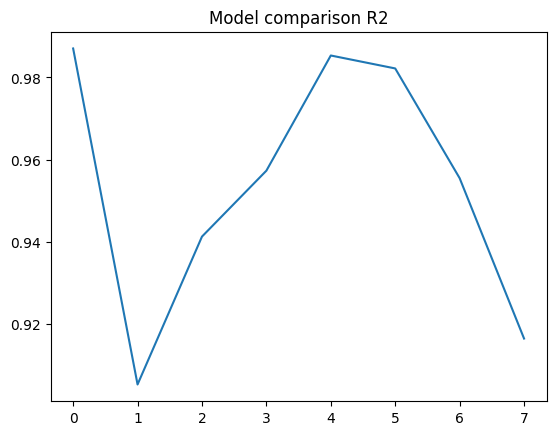

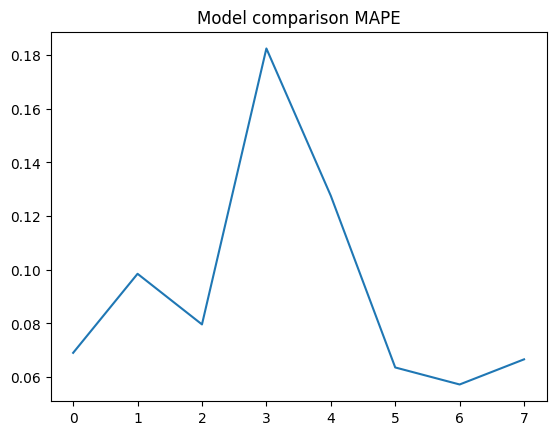

In [16]:
TRAIN_LENGTH = 16
VERIFICATION_LENGTH = 7

folders = [
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} DecisionTreeRegressor'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} RandomForestRegressor'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=30 Gamma=0.1'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=30 Gamma=0.1'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=30 Gamma=0.1'),
    (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=30 Gamma=0.1'),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=30 Gamma=0.1')
]

R2s = []
MAPEs = []

# Loop over all folders
for folder in folders:
    file = f'./{folder}/metric.txt'

    with open(file, 'r') as file:
        # read the contents of the file
        contents = file.read()
        
        # split in rows of file
        parts = contents.split('\n')

        # extract r2
        r2 = parts[0][4:]
        R2s.append(float(r2))

        # extract mape
        mape = parts[1][6:]
        MAPEs.append(float(mape))

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison R2')

# plot the expected data as dots
plt.plot(range(len(folders)), R2s)

# Save the image
plt.savefig('model_comparison_R2.png')

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison MAPE')

# plot the expected data as dots
plt.plot(range(len(folders)), MAPEs)

# Save the image
plt.savefig('model_comparison_MAPE.png')


# Hypertune models

In [14]:



# models = [
#     # ('LinearRegression', LinearRegression()),  -- Delete to bad
#     # ('DecisionTreeRegressor', DecisionTreeRegressor()), -- Delete overfitting
#     # ('RandomForestRegressor', RandomForestRegressor()), -- Delete overfitting
#     # ('SVR 100', SVR(C=100)), -- Delted used poly kernel 
#     # ('SVR 98', SVR(C=98)), - Delted used poly kernel 
#     # ('SVR 95', SVR(C=95)), - Delted used poly kernel 
#     # ('SVR 90', SVR(C=90)), - Delted used poly kernel 
#     # ('GradientBoostingRegressor', GradientBoostingRegressor()) -- Delete to bad
# ]

# # for degree in [2, 3, 4, 5]:
# #     for c in [30]:
# #         for gamma in ['auto', 0.01, 0.1, 0.5]:
# #             models.append((f'SVR poly {degree} C {c} Gamma {gamma}', SVR(kernel='poly', degree=degree, C=c, gamma=gamma)))

# models = [
#     (f'SVR poly', SVR(kernel='poly', degree=3, C=30, gamma=0.1))
# ]

# # Loop over all models
# for name, model in models:
#     print("Trying model:", name)

#     directory = f'./{name}'

#     clean_output(directory)
#     clean_output(f'{directory}/Gemeinden')

#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_verification)

#     coeff = get_coeff(model)

#     evaluate(directory, y_verification, y_pred, zip(x_verification.columns, coeff))

#     plot_gemeinde(directory, 
#         gemeinden, 
#         jahre_train, 
#         jahre_verification,
#         [x_train, x_verification], 
#         [pd.Series(y_train, name='y'), pd.Series(y_verification, name='y')], 
#         [pd.Series(model.predict(x_train), name='pred'), pd.Series(y_pred, name='pred')]
#     )
    
#     plot_gemeinde_typologie(directory, x_verification, pd.Series(y_verification, name='y'), pd.Series(y_pred, name='pred'))

In [15]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# model = LinearRegression()

# poly_column_names = x_columns.copy().to_numpy()

# for degree in range(1, 5):   
#     print("Trying model with degree:", degree)
#     directory = f'./PolynomialLinearRegression{degree}'

#     clean_output(directory)

#     poly = PolynomialFeatures(degree=degree, include_bias=True)

#     x_train_poly_features = pd.DataFrame(poly.fit_transform(x_train))
#     x_verification_poly_features = pd.DataFrame(poly.fit_transform(x_verification))

#     poly_column_names = np.concatenate((poly_column_names, [f'poly{degree}{x}' for x in range(x_train_poly_features.shape[1] - len(poly_column_names))]), axis=0)

#     x_train_poly_features.columns = poly_column_names
#     x_verification_poly_features.columns = poly_column_names


#     model.fit(x_train_poly_features, y_train)
#     y_pred = model.predict(x_verification_poly_features)

#     coeff = get_coeff(model)

#     evaluate(directory, y_verification, y_pred, coeff)
    
#     # plot_gemeinde(directory, 
#     #     [x_train_poly_features, x_verification_poly_features], 
#     #     [pd.Series(y_train, name='y'), pd.Series(y_verification, name='y')], 
#     #     [pd.Series(model.predict(x_train_poly_features), name='pred'), pd.Series(y_pred, name='pred')]
#     # )

#     # plot_gemeinde_typologie(directory, x_train_poly_features, y_verification, y_pred)
    

In [133]:
TRAIN_LENGTH = 14
VERIFICATION_LENGTH = 8

# m = []
# for deg in range(1, 6):
#     for c in [1, 5, 10, 30, 50, 100]:
#         for gamma in [0.1, 0.01]:
#             m.append((f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY{deg} C={c} Gamma={gamma}', SVR(kernel='poly', degree=deg, C=c, gamma=gamma)))

# for learning_rate in []:
#     for n_estimators in []:
#         m.append((f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate {learning_rate} n_estimators {n_estimators}', GradientBoostingRegressor(learning_rate = learning_rate, n_estimators = n_estimators)))




MODELS = [
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=1 Gamma=0.1', SVR(kernel='poly', degree=1, C=1, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=1 Gamma=0.1', SVR(kernel='poly', degree=2, C=1, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=1 Gamma=0.1', SVR(kernel='poly', degree=3, C=1, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=1 Gamma=0.1', SVR(kernel='poly', degree=4, C=1, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=1 Gamma=0.1', SVR(kernel='poly', degree=5, C=1, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=5 Gamma=0.1', SVR(kernel='poly', degree=1, C=5, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=5 Gamma=0.1', SVR(kernel='poly', degree=2, C=5, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=5 Gamma=0.1', SVR(kernel='poly', degree=3, C=5, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=5 Gamma=0.1', SVR(kernel='poly', degree=4, C=5, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=5 Gamma=0.1', SVR(kernel='poly', degree=5, C=5, gamma=0.1)),
    
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=10 Gamma=0.1', SVR(kernel='poly', degree=1, C=10, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=10 Gamma=0.1', SVR(kernel='poly', degree=2, C=10, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=10 Gamma=0.1', SVR(kernel='poly', degree=3, C=10, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=10 Gamma=0.1', SVR(kernel='poly', degree=4, C=10, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=10 Gamma=0.1', SVR(kernel='poly', degree=5, C=10, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=30 Gamma=0.1', SVR(kernel='poly', degree=1, C=30, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=30 Gamma=0.1', SVR(kernel='poly', degree=2, C=30, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=30 Gamma=0.1', SVR(kernel='poly', degree=3, C=30, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=30 Gamma=0.1', SVR(kernel='poly', degree=4, C=30, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=30 Gamma=0.1', SVR(kernel='poly', degree=5, C=30, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=50 Gamma=0.1', SVR(kernel='poly', degree=1, C=50, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=50 Gamma=0.1', SVR(kernel='poly', degree=2, C=50, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=50 Gamma=0.1', SVR(kernel='poly', degree=3, C=50, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=50 Gamma=0.1', SVR(kernel='poly', degree=4, C=50, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=50 Gamma=0.1', SVR(kernel='poly', degree=5, C=50, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=100 Gamma=0.1', SVR(kernel='poly', degree=1, C=100, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=100 Gamma=0.1', SVR(kernel='poly', degree=2, C=100, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=100 Gamma=0.1', SVR(kernel='poly', degree=3, C=100, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=100 Gamma=0.1', SVR(kernel='poly', degree=4, C=100, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=100 Gamma=0.1', SVR(kernel='poly', degree=5, C=100, gamma=0.1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=1 Gamma=0.01', SVR(kernel='poly', degree=1, C=1, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=1 Gamma=0.01', SVR(kernel='poly', degree=2, C=1, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=1 Gamma=0.01', SVR(kernel='poly', degree=3, C=1, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=1 Gamma=0.01', SVR(kernel='poly', degree=4, C=1, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=1 Gamma=0.01', SVR(kernel='poly', degree=5, C=1, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=5 Gamma=0.01', SVR(kernel='poly', degree=1, C=5, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=5 Gamma=0.01', SVR(kernel='poly', degree=2, C=5, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=5 Gamma=0.01', SVR(kernel='poly', degree=3, C=5, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=5 Gamma=0.01', SVR(kernel='poly', degree=4, C=5, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=5 Gamma=0.01', SVR(kernel='poly', degree=5, C=5, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=10 Gamma=0.01', SVR(kernel='poly', degree=1, C=10, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=10 Gamma=0.01', SVR(kernel='poly', degree=2, C=10, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=10 Gamma=0.01', SVR(kernel='poly', degree=3, C=10, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=10 Gamma=0.01', SVR(kernel='poly', degree=4, C=10, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=10 Gamma=0.01', SVR(kernel='poly', degree=5, C=10, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=30 Gamma=0.01', SVR(kernel='poly', degree=1, C=30, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=30 Gamma=0.01', SVR(kernel='poly', degree=2, C=30, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=30 Gamma=0.01', SVR(kernel='poly', degree=3, C=30, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=30 Gamma=0.01', SVR(kernel='poly', degree=4, C=30, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=30 Gamma=0.01', SVR(kernel='poly', degree=5, C=30, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=50 Gamma=0.01', SVR(kernel='poly', degree=1, C=50, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=50 Gamma=0.01', SVR(kernel='poly', degree=2, C=50, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=50 Gamma=0.01', SVR(kernel='poly', degree=3, C=50, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=50 Gamma=0.01', SVR(kernel='poly', degree=4, C=50, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=50 Gamma=0.01', SVR(kernel='poly', degree=5, C=50, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY1 C=100 Gamma=0.01', SVR(kernel='poly', degree=1, C=100, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY2 C=100 Gamma=0.01', SVR(kernel='poly', degree=2, C=100, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY3 C=100 Gamma=0.01', SVR(kernel='poly', degree=3, C=100, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY4 C=100 Gamma=0.01', SVR(kernel='poly', degree=4, C=100, gamma=0.01)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} SVR POLY5 C=100 Gamma=0.01', SVR(kernel='poly', degree=5, C=100, gamma=0.01)),

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 1', KNeighborsRegressor(n_neighbors=1)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 2', KNeighborsRegressor(n_neighbors=2)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 3', KNeighborsRegressor(n_neighbors=3)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 4', KNeighborsRegressor(n_neighbors=4)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 5', KNeighborsRegressor(n_neighbors=5)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 6', KNeighborsRegressor(n_neighbors=6)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 7', KNeighborsRegressor(n_neighbors=7)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} KNeighborsRegressor 8', KNeighborsRegressor(n_neighbors=8)),

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} LinearRegression', LinearRegression()),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} DecisionTreeRegressor', DecisionTreeRegressor()),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} RandomForestRegressor', RandomForestRegressor())
    
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.05 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.05, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.1 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.2 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.3 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.3, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.4 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.5 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.5, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.6 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.6, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.7 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.7, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.8 n_estimators 50', GradientBoostingRegressor(learning_rate = 0.8, n_estimators = 50)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 1.0 n_estimators 50', GradientBoostingRegressor(learning_rate = 1.0, n_estimators = 50)),

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.05 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.05, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.1 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.2 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.3 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.3, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.4 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.5 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.5, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.6 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.6, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.7 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.7, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.8 n_estimators 100', GradientBoostingRegressor(learning_rate = 0.8, n_estimators = 100)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 1.0 n_estimators 100', GradientBoostingRegressor(learning_rate = 1.0, n_estimators = 100)),

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.05 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.05, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.1 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.2 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.3 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.3, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.4 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.5 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.5, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.6 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.6, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.7 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.7, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.8 n_estimators 200', GradientBoostingRegressor(learning_rate = 0.8, n_estimators = 200)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 1.0 n_estimators 200', GradientBoostingRegressor(learning_rate = 1.0, n_estimators = 200)),

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.05 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.05, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.1 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.2 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.3 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.3, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.4 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.5 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.5, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.6 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.6, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.7 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.7, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.8 n_estimators 500', GradientBoostingRegressor(learning_rate = 0.8, n_estimators = 500)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 1.0 n_estimators 500', GradientBoostingRegressor(learning_rate = 1.0, n_estimators = 500))

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.05 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.05, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.1 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.2 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.3 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.3, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.4 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.5 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.5, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.6 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.6, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.7 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.7, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.8 n_estimators 800', GradientBoostingRegressor(learning_rate = 0.8, n_estimators = 800)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 1.0 n_estimators 800', GradientBoostingRegressor(learning_rate = 1.0, n_estimators = 800)),

    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.05 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.05, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.1 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.2 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.3 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.3, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.4 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.5 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.5, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.6 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.6, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.7 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.7, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 0.8 n_estimators 1000', GradientBoostingRegressor(learning_rate = 0.8, n_estimators = 1000)),
    # (f'T{TRAIN_LENGTH} V{VERIFICATION_LENGTH} GradientBoostingRegressor learning_rate 1.0 n_estimators 1000', GradientBoostingRegressor(learning_rate = 1.0, n_estimators = 1000))
]

# Load data if not already loaded
if 'data' not in locals() or 'data' not in globals():
    data = read_excel()

# Split
train, verification, test = train_verification_test_split(data, TRAIN_LENGTH, VERIFICATION_LENGTH)

x_train, y_train = x_y_split(train)
x_verification, y_verification = x_y_split(verification)
x_test, y_test = x_y_split(test)

# Set dummy variables
x_train = set_dummy_variables(x_train)
x_verification = set_dummy_variables(x_verification)
x_test = set_dummy_variables(x_test)

# Extract data for visualisations before scaling
jahre_train = get_jahre(x_train)
jahre_verification = get_jahre(x_verification)
gemeinden, gemeinden_typologien = get_gemeinde_and_gemeindetypologien(x_test)

# Scale the data
x_train, scaler = scale(x_train, None)
x_verification, scaler = scale(x_verification, scaler)
x_test, scaler = scale(x_test, scaler)

for name, model in MODELS:
    print("Trying model:", name)

    # Prepare folder for output
    directory = clean_output(name)

    # Train Model
    model.fit(x_train, y_train)

    # Prediction
    y_pred_train = pd.Series(model.predict(x_train), name = 'pred')
    y_pred_verification = pd.Series(model.predict(x_verification), name = 'pred')
    
    # Evaluation
    coeff = get_coeff(model)

    evaluate(directory, y_verification, y_pred_verification, zip(x_verification.columns, coeff))

    plot_gemeinde(directory, 
        gemeinden, 
        jahre_train, 
        jahre_verification,
        [x_train, x_verification], 
        [y_train, y_verification], 
        [y_pred_train, y_pred_verification]
        )
    
    plot_gemeinde_typologie(directory, 
                            gemeinden_typologien, 
                            x_verification, 
                            y_verification,
                            y_pred_verification
                            )


IndentationError: expected an indented block after 'for' statement on line 11 (1041940217.py, line 13)

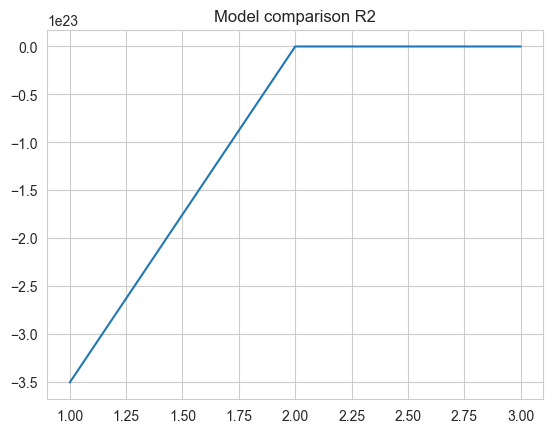

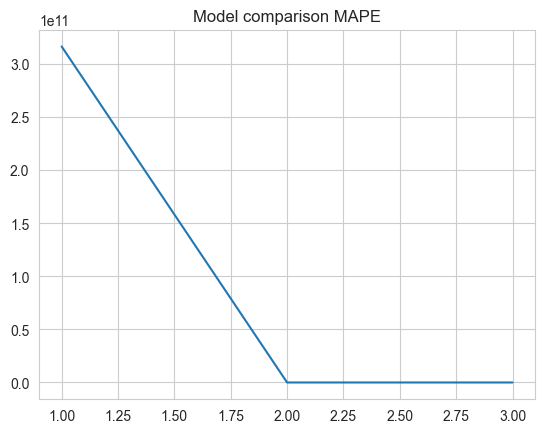

In [105]:

folders = [
    'T14 V8 LinearRegression',
    'T14 V8 DecisionTreeRegressor',
    'T14 V8 RandomForestRegressor'
]

R2s = []
MAPEs = []

# Loop over all folders
for folder in folders:
    file = f'./{folder}/metric.txt'

    with open(file, 'r') as file:
        # read the contents of the file
        contents = file.read()
        
        # split in rows of file
        parts = contents.split('\n')

        # extract r2
        r2 = parts[0][4:]
        R2s.append(float(r2))

        # extract mape
        mape = parts[1][6:]
        MAPEs.append(float(mape))

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison R2')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), R2s)

# Save the image
plt.savefig('model_comparison_R2.png')

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison MAPE')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), MAPEs)

# Save the image
plt.savefig('model_comparison_MAPE.png')


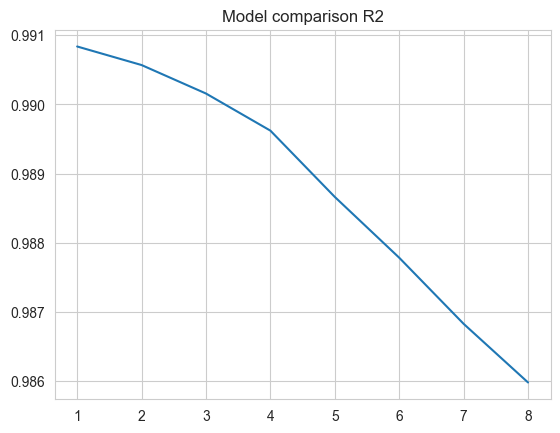

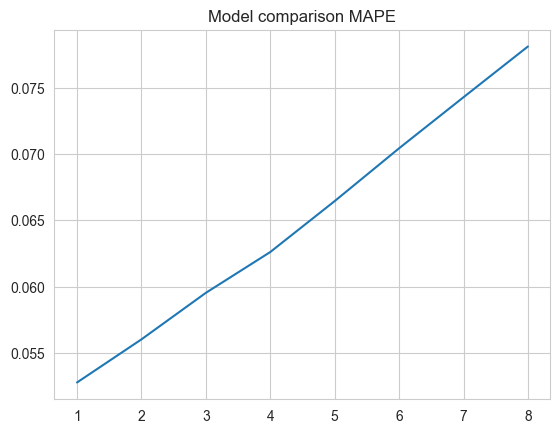

In [106]:
folders = [
    'T14 V8 KNeighborsRegressor 1',
    'T14 V8 KNeighborsRegressor 2',
    'T14 V8 KNeighborsRegressor 3',
    'T14 V8 KNeighborsRegressor 4',
    'T14 V8 KNeighborsRegressor 5',
    'T14 V8 KNeighborsRegressor 6',
    'T14 V8 KNeighborsRegressor 7',
    'T14 V8 KNeighborsRegressor 8'
]

R2s = []
MAPEs = []

# Loop over all folders
for folder in folders:
    file = f'./{folder}/metric.txt'

    with open(file, 'r') as file:
        # read the contents of the file
        contents = file.read()
        
        # split in rows of file
        parts = contents.split('\n')

        # extract r2
        r2 = parts[0][4:]
        R2s.append(float(r2))

        # extract mape
        mape = parts[1][6:]
        MAPEs.append(float(mape))

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison R2')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), R2s)

# Save the image
plt.savefig('model_comparison_R2.png')

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison MAPE')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), MAPEs)

# Save the image
plt.savefig('model_comparison_MAPE.png')


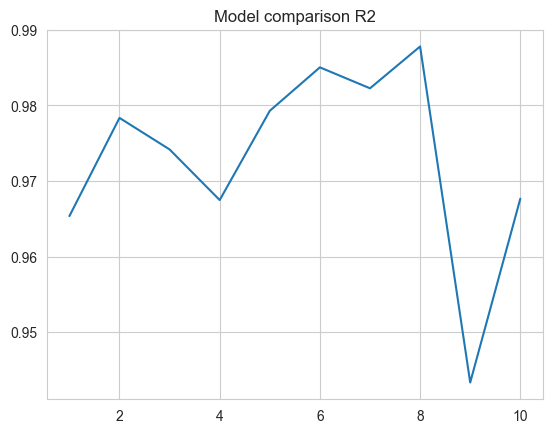

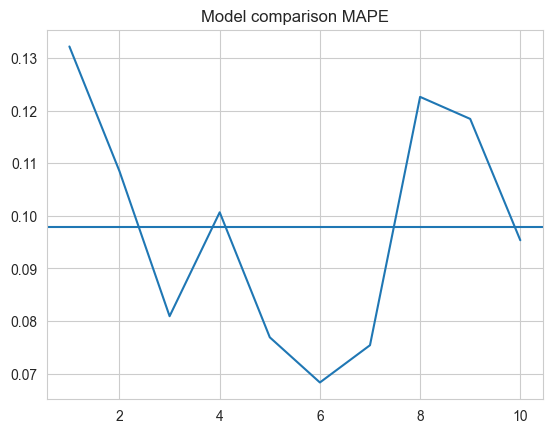

In [102]:
folders1 = [
    'T14 V8 GradientBoostingRegressor learning_rate 0.05 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.1 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.2 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.3 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.4 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.5 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.6 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.7 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 0.8 n_estimators 50',
    'T14 V8 GradientBoostingRegressor learning_rate 1.0 n_estimators 50'
]

folders2 = [
    'T14 V8 GradientBoostingRegressor learning_rate 0.05 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.1 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.2 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.3 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.4 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.5 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.6 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.7 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 0.8 n_estimators 100',
    'T14 V8 GradientBoostingRegressor learning_rate 1.0 n_estimators 100'
]

folders3 = [     
    'T14 V8 GradientBoostingRegressor learning_rate 0.05 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.1 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.3 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.4 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.5 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.2 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.6 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.7 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 0.8 n_estimators 200',
    'T14 V8 GradientBoostingRegressor learning_rate 1.0 n_estimators 200'
]

folders4 = [
    'T14 V8 GradientBoostingRegressor learning_rate 0.05 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.1 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.2 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.3 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.4 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.5 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.6 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.7 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 0.8 n_estimators 500',
    'T14 V8 GradientBoostingRegressor learning_rate 1.0 n_estimators 500'
]

folders5 = [
    'T14 V8 GradientBoostingRegressor learning_rate 0.05 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.1 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.2 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.3 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.4 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.5 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.6 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.7 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 0.8 n_estimators 800',
    'T14 V8 GradientBoostingRegressor learning_rate 1.0 n_estimators 800'
]

folders6 = [
    'T14 V8 GradientBoostingRegressor learning_rate 0.05 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.1 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.2 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.3 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.4 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.5 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.6 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.7 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 0.8 n_estimators 1000',
    'T14 V8 GradientBoostingRegressor learning_rate 1.0 n_estimators 1000'
]

folders = folders4 + folders5 + folders6

R2s = []
MAPEs = []

# Loop over all folders
for folder in folders:
    file = f'./{folder}/metric.txt'

    with open(file, 'r') as file:
        # read the contents of the file
        contents = file.read()
        
        # split in rows of file
        parts = contents.split('\n')

        # extract r2
        r2 = parts[0][4:]
        R2s.append(float(r2))

        # extract mape
        mape = parts[1][6:]
        MAPEs.append(float(mape))

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison R2')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), R2s)

# Save the image
plt.savefig('model_comparison_R2.png')

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison MAPE')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), MAPEs)

plt.axhline(y=np.nanmean(MAPEs))

# Save the image
plt.savefig('model_comparison_MAPE.png')


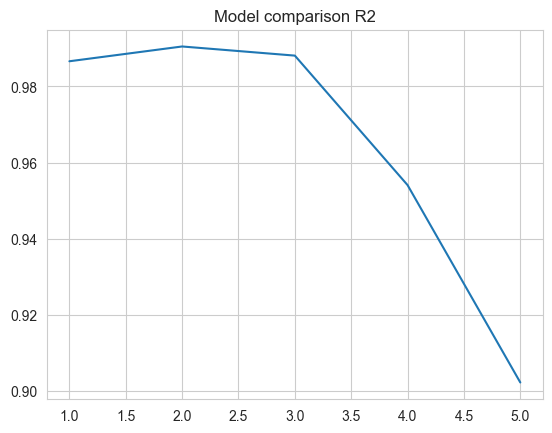

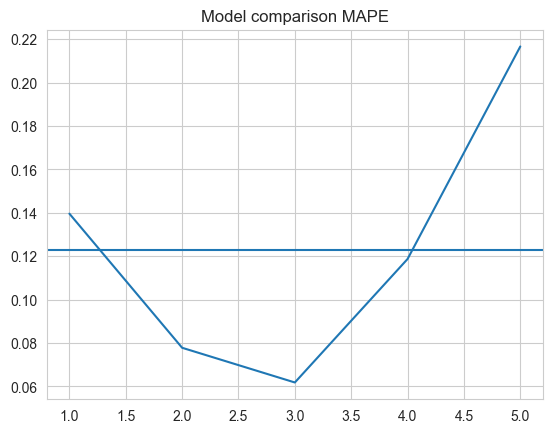

In [130]:
folders1 = [
    'T14 V8 SVR POLY1 C=10 Gamma=0.1',
    'T14 V8 SVR POLY1 C=30 Gamma=0.1',
    'T14 V8 SVR POLY1 C=50 Gamma=0.1',
    'T14 V8 SVR POLY1 C=100 Gamma=0.1',
]

folders2 = [
    'T14 V8 SVR POLY2 C=10 Gamma=0.1',
    'T14 V8 SVR POLY2 C=30 Gamma=0.1',
    'T14 V8 SVR POLY2 C=50 Gamma=0.1',
    'T14 V8 SVR POLY2 C=100 Gamma=0.1',
]

folders3 = [
    'T14 V8 SVR POLY3 C=10 Gamma=0.1',
    'T14 V8 SVR POLY3 C=30 Gamma=0.1',
    'T14 V8 SVR POLY3 C=50 Gamma=0.1',
    'T14 V8 SVR POLY3 C=100 Gamma=0.1',
]

folders4 = [       
    'T14 V8 SVR POLY4 C=10 Gamma=0.1',
    'T14 V8 SVR POLY4 C=30 Gamma=0.1',
    'T14 V8 SVR POLY4 C=50 Gamma=0.1',
    'T14 V8 SVR POLY4 C=100 Gamma=0.1',
]

folders5 = [
    'T14 V8 SVR POLY5 C=10 Gamma=0.1',
    'T14 V8 SVR POLY5 C=30 Gamma=0.1',
    'T14 V8 SVR POLY5 C=50 Gamma=0.1',
    'T14 V8 SVR POLY5 C=100 Gamma=0.1'
]


folders6 = [
 'T14 V8 SVR POLY1 C=10 Gamma=0.1',
 'T14 V8 SVR POLY2 C=10 Gamma=0.1',
 'T14 V8 SVR POLY3 C=10 Gamma=0.1',
 'T14 V8 SVR POLY4 C=10 Gamma=0.1',
 'T14 V8 SVR POLY5 C=10 Gamma=0.1'   
]

folders7 = [
 'T14 V8 SVR POLY1 C=30 Gamma=0.1',
 'T14 V8 SVR POLY2 C=30 Gamma=0.1',
 'T14 V8 SVR POLY3 C=30 Gamma=0.1',
 'T14 V8 SVR POLY4 C=30 Gamma=0.1',
 'T14 V8 SVR POLY5 C=30 Gamma=0.1'   
]

folders8 = [
 'T14 V8 SVR POLY1 C=50 Gamma=0.1',
 'T14 V8 SVR POLY2 C=50 Gamma=0.1',
 'T14 V8 SVR POLY3 C=50 Gamma=0.1',
 'T14 V8 SVR POLY4 C=50 Gamma=0.1',
 'T14 V8 SVR POLY5 C=50 Gamma=0.1'   
]

folders9 = [
 'T14 V8 SVR POLY1 C=100 Gamma=0.1',
 'T14 V8 SVR POLY2 C=100 Gamma=0.1',
 'T14 V8 SVR POLY3 C=100 Gamma=0.1',
 'T14 V8 SVR POLY4 C=100 Gamma=0.1',
 'T14 V8 SVR POLY5 C=100 Gamma=0.1'   
]

folders10 = [
    'T14 V8 SVR POLY1 C=10 Gamma=0.01',
    'T14 V8 SVR POLY1 C=30 Gamma=0.01',
    'T14 V8 SVR POLY1 C=50 Gamma=0.01',
    'T14 V8 SVR POLY1 C=100 Gamma=0.01',
]

folders11 = [
    'T14 V8 SVR POLY2 C=10 Gamma=0.01',
    'T14 V8 SVR POLY2 C=30 Gamma=0.01',
    'T14 V8 SVR POLY2 C=50 Gamma=0.01',
    'T14 V8 SVR POLY2 C=100 Gamma=0.01',
]

folders12 = [
    'T14 V8 SVR POLY3 C=10 Gamma=0.01',
    'T14 V8 SVR POLY3 C=30 Gamma=0.01',
    'T14 V8 SVR POLY3 C=50 Gamma=0.01',
    'T14 V8 SVR POLY3 C=100 Gamma=0.01',
]

folders13 = [       
    'T14 V8 SVR POLY4 C=10 Gamma=0.01',
    'T14 V8 SVR POLY4 C=30 Gamma=0.01',
    'T14 V8 SVR POLY4 C=50 Gamma=0.01',
    'T14 V8 SVR POLY4 C=100 Gamma=0.01',
]

folders14 = [
    'T14 V8 SVR POLY5 C=10 Gamma=0.01',
    'T14 V8 SVR POLY5 C=30 Gamma=0.01',
    'T14 V8 SVR POLY5 C=50 Gamma=0.01',
    'T14 V8 SVR POLY5 C=100 Gamma=0.01'
]


folders15 = [
 'T14 V8 SVR POLY1 C=10 Gamma=0.01',
 'T14 V8 SVR POLY2 C=10 Gamma=0.01',
 'T14 V8 SVR POLY3 C=10 Gamma=0.01',
 'T14 V8 SVR POLY4 C=10 Gamma=0.01',
 'T14 V8 SVR POLY5 C=10 Gamma=0.01'   
]

folders16 = [
 'T14 V8 SVR POLY1 C=30 Gamma=0.01',
 'T14 V8 SVR POLY2 C=30 Gamma=0.01',
 'T14 V8 SVR POLY3 C=30 Gamma=0.01',
 'T14 V8 SVR POLY4 C=30 Gamma=0.01',
 'T14 V8 SVR POLY5 C=30 Gamma=0.01'   
]

folders17 = [
 'T14 V8 SVR POLY1 C=50 Gamma=0.01',
 'T14 V8 SVR POLY2 C=50 Gamma=0.01',
 'T14 V8 SVR POLY3 C=50 Gamma=0.01',
 'T14 V8 SVR POLY4 C=50 Gamma=0.01',
 'T14 V8 SVR POLY5 C=50 Gamma=0.01'   
]

folders18 = [
 'T14 V8 SVR POLY1 C=100 Gamma=0.01',
 'T14 V8 SVR POLY2 C=100 Gamma=0.01',
 'T14 V8 SVR POLY3 C=100 Gamma=0.01',
 'T14 V8 SVR POLY4 C=100 Gamma=0.01',
 'T14 V8 SVR POLY5 C=100 Gamma=0.01'   
]




folders = folders9

R2s = []
MAPEs = []

# Loop over all folders
for folder in folders:
    file = f'./{folder}/metric.txt'

    with open(file, 'r') as file:
        # read the contents of the file
        contents = file.read()
        
        # split in rows of file
        parts = contents.split('\n')

        # extract r2
        r2 = parts[0][4:]
        R2s.append(float(r2))

        # extract mape
        mape = parts[1][6:]
        MAPEs.append(float(mape))

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison R2')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), R2s)

# Save the image
plt.savefig('model_comparison_R2.png')

# Plot the data
plt.figure()

# Set title on plot
plt.title('Model comparison MAPE')

# plot the expected data as dots
plt.plot(range(1, len(folders) + 1), MAPEs)

plt.axhline(y=np.nanmean(MAPEs))

# Save the image
plt.savefig('model_comparison_MAPE.png')
